In [ ]:
import mlflow.pyfunc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### 1 - Using Pandas 

In [ ]:
# Load model
model_name = "Best_Model"
model_uri = f"models:/{model_name}@Champion"
model = mlflow.pyfunc.load_model(model_uri)

# Load new data
new_data_spark = spark.table("db_pegah.default.heart_disease_test")
new_data_panda = new_data_spark.toPandas()

x_new = new_data_panda.drop('target' , axis=1 ) 
y_true = new_data_panda['target']

# Apply model to get predictions
y_pred = model.predict(x_new)
new_data_panda["prediction"] = y_pred
new_data_panda.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction
11,67,1,0,100,299,0,0,125,1,0.9,1,2,2,0,0
59,48,1,0,122,222,0,0,186,0,0.0,2,0,2,1,1
36,51,1,2,100,222,0,1,143,1,1.2,1,0,2,1,1
0,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0,0
39,60,1,0,117,230,1,1,160,1,1.4,2,2,3,0,0
27,50,0,2,120,219,0,1,158,0,1.6,1,0,2,1,1
29,54,1,2,150,232,0,0,165,0,1.6,2,0,3,1,1
47,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,1
50,45,1,0,115,260,0,0,185,0,0.0,2,0,2,1,1
58,41,1,2,130,214,0,0,168,0,2.0,1,0,2,1,1


### 2 - Using Spark UDF 

In [ ]:
from pyspark.sql.functions import struct

In [ ]:
# Load model as a Spark UDF
model_name = "Best_Model"
model_uri = f"models:/{model_name}@Champion"
model_udf = mlflow.pyfunc.spark_udf(spark, model_uri)

# Load new data
new_data_spark = spark.table("db_pegah.default.heart_disease_test")

# Prepare the input structure for the UDF
udf_inputs = struct(*(new_data_spark.columns[:-1])) 

# Apply the UDF to get predictions
df = new_data_spark.withColumn("prediction", model_udf(udf_inputs))
df.show(10)

2024/08/21 03:53:21 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.
2024/08/21 03:53:21 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+----------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|prediction|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+----------+
| 46|  1|  0|     140| 311|  0|      1|    120|    1|    1.8|    1|  2|   3|     0|       [0]|
| 43|  1|  0|     132| 247|  1|      0|    143|    1|    0.1|    1|  4|   3|     0|       [0]|
| 52|  1|  1|     128| 205|  1|      1|    184|    0|    0.0|    2|  0|   2|     1|       [1]|
| 58|  1|  2|     105| 240|  0|      0|    154|    1|    0.6|    1|  0|   3|     1|       [0]|
| 71|  0|  2|     110| 265|  1|      0|    130|    0|    0.0|    2|  1|   2|     1|       [1]|
| 52|  1|  2|     138| 223|  0|      1|    169|    0|    0.0|    2|  4|   2|     1|       [1]|
| 58|  1|  0|     150| 270|  0|      0|    111|    1|    0.8|    2|  0|   3|     0|       [0]|
| 62|  0|  0|     124| 209|  0|      1|    163|   

### Performance on Unseen Data


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.73        24
           1       0.83      0.81      0.82        37

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



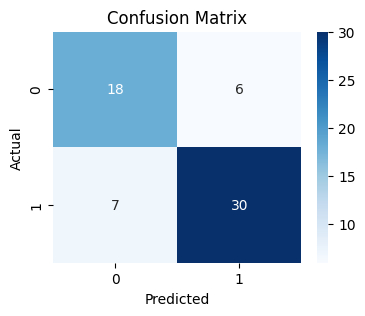

In [ ]:
classification_rep = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_rep)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()